In [199]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from pathlib import Path
import plumed
import torch
torch.manual_seed(42)
from skmatter.feature_selection import FPS
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Subset
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.ticker as ticker
from scipy.interpolate import griddata

In [3]:
PLUMED_EXE="plumed"

subprocess.run(f"{PLUMED_EXE}", shell=True)

def clean(folder='./'):
    subprocess.run("rm COLVAR KERNELS bck.* out* histogram* *log potential-coeffs.out.data stats.out", cwd=folder, shell=True)

Nothing to do. Use 'plumed help' for help


In [4]:
def muller_brown_potential_three_states(x, y):
    """Muller-Brown analytical potential"""
    prefactor = 0.15
    A = (-280, -170, -170, 15)
    a = (-15, -1, -6.5, 0.7)
    b = (0, 0, 11, 0.6)
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0.2, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)
    offset = -146.7

    v = -prefactor * offset
    for i in range(4):
        v += (
            prefactor
            * A[i]
            * np.exp(
                a[i] * (x - x0[i]) ** 2
                + b[i] * (x - x0[i]) * (y - y0[i])
                + c[i] * (y - y0[i]) ** 2
            )
        )
    return v
MULLER_BROWN_FORMULA='0.15*(146.7-280*exp(-15*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-170*exp(-1*(x-0.2)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

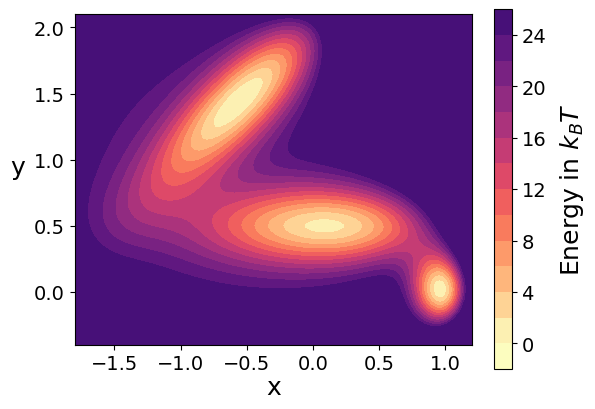

In [5]:
nx, ny = (100, 100)
xlims = (-1.8, 1.2)
ylims = (-0.4, 2.1)
x = np.linspace(xlims[0], xlims[1], nx)
y = np.linspace(ylims[0], ylims[1], ny)
xv, yv = np.meshgrid(x, y)

pot = muller_brown_potential_three_states(xv, yv)
max_pot = 26
pot[pot > max_pot] = max_pot  

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  

fig, ax = plt.subplots(dpi=100)
norm = mcolors.Normalize(vmin=np.min(pot), vmax=max_pot)  
pp = ax.contourf(xv, yv, pot, 16, cmap=new_magma, norm=norm)  
ax.set_aspect('equal')

cbar = plt.colorbar(pp, ax=ax)
cbar.ax.set_position([0.78, 0.1, 0.05, 0.75])  

cbar.set_label(r'Energy in $k_BT$', rotation=90, labelpad=8, fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18,labelpad=1)
plt.ylabel('y', rotation=0,fontsize=18,labelpad=12)
plt.show()


In [6]:
#ABMD

In [ ]:
!mkdir raw_data

In [12]:
kappas=[80] #[50,55,60,65,70]

for i in range(1,2):
    folder = 'raw_data/AB%s/'%str(i)

    Path(folder).mkdir(parents=True, exist_ok=True)

    with open(folder+"md_potential","w") as f:
        print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

    with open(folder+"md_input","w") as f:
        print("""
nstep                   10000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             2  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        0.9,0.0
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

    with open(folder+"plumed.dat","w") as f:
        print(f"""# vim:ft=plumed
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

abmd: ABMD ARG=p.y TO=1.5 KAPPA=%s

COMMITTOR ...
   ARG=p.x,p.y
   STRIDE=1
   BASIN_LL1=0,0.4
   BASIN_UL1=0.1,0.55
...

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.5

PRINT STRIDE=1 ARG=* FILE=COLVAR_ABMD_kappa%s
"""%(str(kappas[i-1]),str(kappas[i-1])),file=f)
    clean(folder)
    subprocess.run(f"{PLUMED_EXE} ves_md_linearexpansion < md_input &", cwd=folder, shell=True)

rm: cannot remove 'COLVAR': No such file or directory
rm: cannot remove 'KERNELS': No such file or directory
rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'out*': No such file or directory
rm: cannot remove 'histogram*': No such file or directory
rm: cannot remove '*log': No such file or directory
rm: cannot remove 'potential-coeffs.out.data': No such file or directory
rm: cannot remove 'stats.out': No such file or directory


Replicas                              1
Cores per replica                     1
Number of steps                       10000000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -2
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
Basis Function 2                      BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


14032


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


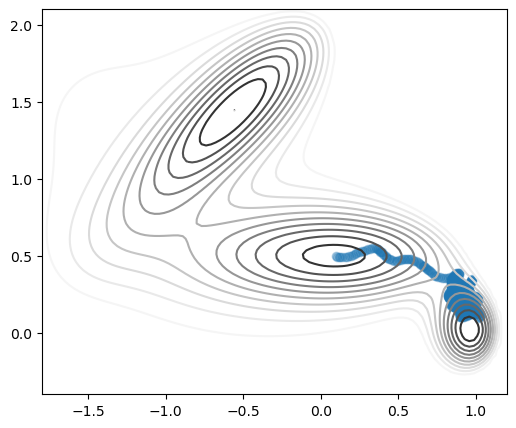

In [8]:
from skmatter.feature_selection import FPS

kappas=[80]

transitions=[]

selector = FPS(n_to_select=200,initialize=0)

for i in range(1,2):
    colvar=plumed.read_as_pandas("raw_data/AB%s/COLVAR_ABMD_kappa%s" %(i,kappas[i-1]))
    print(len(colvar))
    dynamics=np.array(colvar.iloc[::1,:3],dtype=float)[::-1]
    
    transition=[]
    for t in dynamics:

        transition.append(t[1:])

        if t[2] < 0.1:
            break
            
    transitions.append(torch.Tensor(transition))

_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

for i in range(1):
    plt.scatter(transitions[i][:,0], transitions[i][:,1],alpha=0.3)
plt.show()   


In [9]:
kappas=[30]  

for i in range(6,7):
    folder = 'raw_data/AB%s/'%str(i)

    Path(folder).mkdir(parents=True, exist_ok=True)

    with open(folder+"md_potential","w") as f:
        print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

    with open(folder+"md_input","w") as f:
        print("""
nstep                   10000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        -0.6,1.2
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

    with open(folder+"plumed.dat","w") as f:
        print(f"""# vim:ft=plumed
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

abmd: ABMD ARG=p.y TO=0.4 KAPPA=%s

COMMITTOR ...
   ARG=p.x,p.y
   STRIDE=10
   BASIN_LL1=0,0.5
   BASIN_UL1=0.2,0.7
...

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.5

PRINT STRIDE=1 ARG=* FILE=COLVAR_ABMD_kappa%s
"""%(str(kappas[i-6]),str(kappas[i-6])),file=f)
    clean(folder)
    subprocess.run(f"{PLUMED_EXE} ves_md_linearexpansion < md_input &", cwd=folder, shell=True)

rm: cannot remove 'COLVAR': No such file or directory
rm: cannot remove 'KERNELS': No such file or directory
rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'out*': No such file or directory
rm: cannot remove 'histogram*': No such file or directory
rm: cannot remove '*log': No such file or directory
rm: cannot remove 'potential-coeffs.out.data': No such file or directory
rm: cannot remove 'stats.out': No such file or directory


Replicas                              1
Cores per replica                     1
Number of steps                       10000000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -1
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
Basis Function 2                      BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


179541


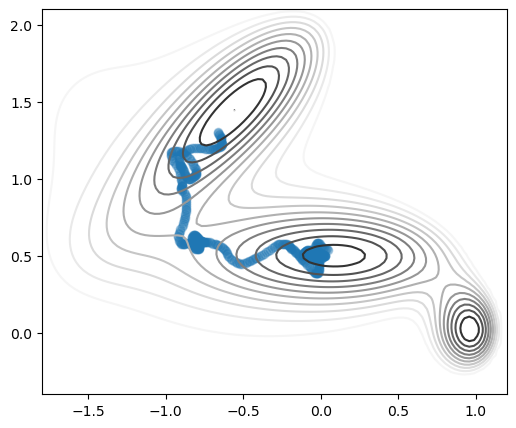

In [10]:
kappas=[30] 

transitions2=[]

selector = FPS(n_to_select=200,initialize=0)

for i in range(6,7):
    colvar=plumed.read_as_pandas("raw_data/AB%s/COLVAR_ABMD_kappa%s" %(i,kappas[i-6]))
    print(len(colvar))
    dynamics=np.array(colvar.iloc[::1,:3],dtype=float)[::-1]
    
    transition=[]
    for t in dynamics:

        transition.append(t[1:])

        if t[2] > 1.3:
            break
            
    transitions2.append(torch.Tensor(transition))

_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

for i in range(1):
    plt.scatter(transitions2[i][:,0], transitions2[i][:,1],alpha=0.3)
plt.show()   


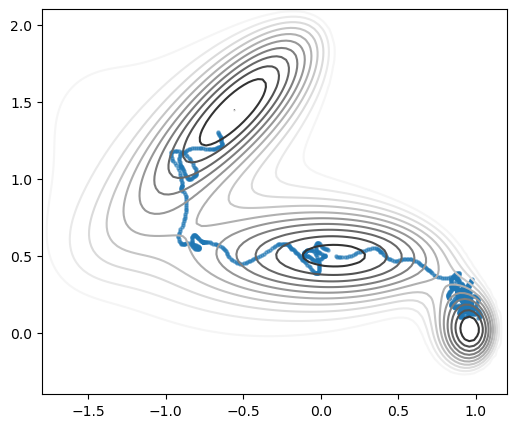

In [11]:
training_batches=[]
for i in range(1):
    training_batches.append(np.vstack((transitions[i],transitions2[i])))
    
training_datapoints=np.concatenate(training_batches)
                            
_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

for i in range(1):
    plt.scatter(training_batches[i][:,0], training_batches[i][:,1],alpha=0.5,s=5)
plt.show()   

In [12]:
print(training_datapoints.shape)
training_batches = np.array_split(training_datapoints, 4)
training_batches=np.array(training_batches)
print(training_batches.shape)

(1103, 2)
(4,)


/tmp/ipykernel_1262811/4100881711.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_batches=np.array(training_batches)


(200, 2)


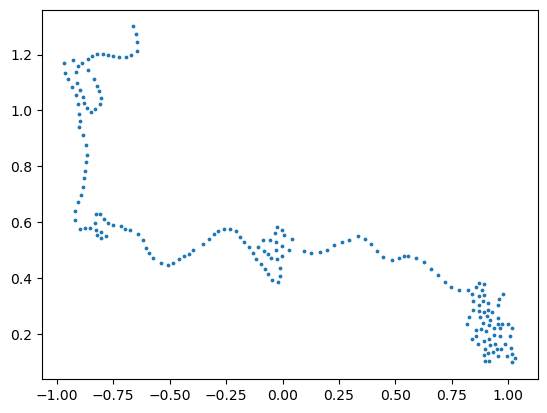

In [13]:
selector = FPS(n_to_select=200,initialize=0)

selector.fit(training_datapoints.T)
model_datapoints = selector.transform(training_datapoints.T).T

print(model_datapoints.shape)

plt.figure()
plt.scatter(model_datapoints[:,0],model_datapoints[:,1],s=3,alpha=1)
plt.show()

In [14]:
#label the 3 states

training_batches_labels=[]
for batch in training_batches:
    #print(batch.shape)
    labels = np.full(batch.shape[0], 2.0)

    center1 = np.array([1.0, 0.0])
    center2 = np.array([0.0, 0.5])
    center3 = np.array([-0.75, 1.35])

    r1 = 0.2  
    r2 = 0.2
    r3 = 0.2

    distances_center1 = np.linalg.norm(batch - center1, axis=1)
    distances_center2 = np.linalg.norm(batch - center2, axis=1)
    distances_center3 = np.linalg.norm(batch - center3, axis=1)

    indices_center1 = np.where(distances_center1 < r1)
    labels[indices_center1] = 0

    indices_center2 = np.where(distances_center2 < r2)
    labels[indices_center2] = 0.5

    indices_center3 = np.where(distances_center3 < r3)
    labels[indices_center3] = 1
    
    training_batches_labels.append(labels)
    
training_datapoints_labels=np.concatenate(training_batches_labels)

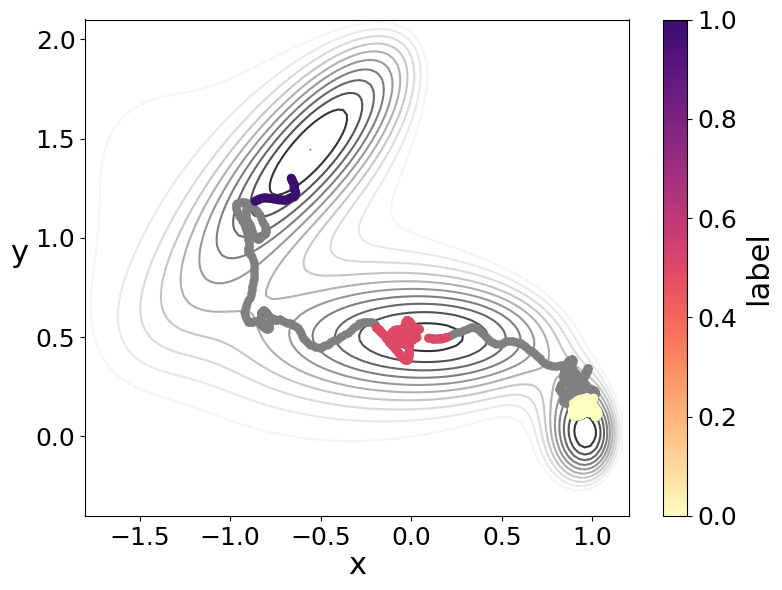

In [17]:
magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)               
ax.contour(xv,yv,pot,10,cmap='Greys_r')
ax.plot(training_datapoints[:,0],training_datapoints[:,1],'o', color='gray',markersize=5)
ndx=np.where((training_datapoints_labels!=2.0))[0]
pp=ax.scatter(training_datapoints[ndx,0],training_datapoints[ndx,1],c=training_datapoints_labels[ndx],s=30,cmap=new_magma,zorder=20)

cbar = plt.colorbar(pp, ax=ax)
cbar.set_label(r'label', rotation=90, labelpad=5,fontsize=22)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22,labelpad=1)
plt.ylabel('y', rotation=0,fontsize=22,labelpad=12)
plt.tight_layout()
plt.show()


In [20]:
dataset = TensorDataset(torch.Tensor(training_datapoints), torch.Tensor(training_datapoints_labels))

In [21]:
device = torch.device("cpu")

In [24]:
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)

# Split dataset into training and validation sets
train_size = int(0.8 * dataset_size)  # 80% for training, 20% for validation
val_size = dataset_size - train_size
train_indices, val_indices = indices[:train_size], indices[train_size:]
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Define batch size for training
batch_size_train = 64

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

val_features = []
val_labels = []
for val_index in val_indices:
    feature, label = dataset[val_index]
    val_features.append(feature)
    val_labels.append(label)

val_features = torch.stack(val_features)  
val_labels = torch.stack(val_labels)  

val_features = val_features.to(device)
val_labels = val_labels.to(device)
val_features.shape

torch.Size([221, 2])

In [25]:
for batch_idx, (features, labels) in enumerate(train_loader):
    if batch_idx == 0 :
        print(features.shape)
        print(labels.shape)
batch_size_train*batch_idx

torch.Size([64, 2])
torch.Size([64])


832

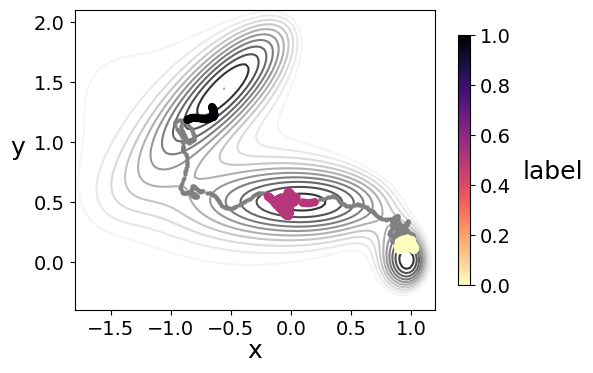

In [26]:
_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

plt.plot(train_dataset[:][0][:,0],train_dataset[:][0][:,1],'o', color='gray',linewidth=1, markersize=2)
ndx=np.where((train_dataset[:][1]!=2.0))[0]
plt.scatter(train_dataset[:][0][ndx,0],train_dataset[:][0][ndx,1],c=train_dataset[:][1][ndx],s=25,cmap='magma_r',zorder=20)
cbar =plt.colorbar(shrink=0.6)
cbar.set_label(r'label', rotation=0, labelpad=30,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18,labelpad=0)
plt.ylabel('y', rotation=0,fontsize=18,labelpad=12)
plt.tight_layout()
ax.set_aspect('equal')
plt.show()

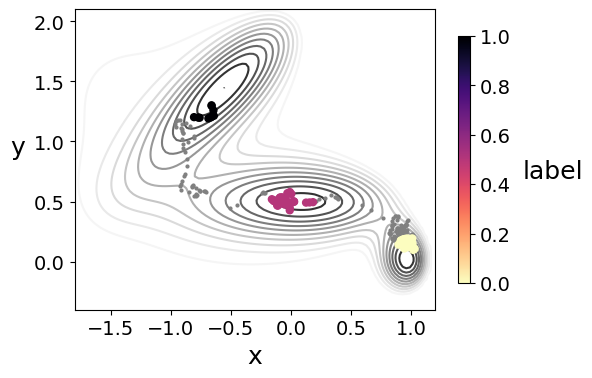

In [28]:
_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

plt.plot(val_dataset[:][0][:,0],val_dataset[:][0][:,1],'o', color='gray',linewidth=1, markersize=2)
ndx=np.where((val_dataset[:][1]!=2.0))[0]
plt.scatter(val_dataset[:][0][ndx,0],val_dataset[:][0][ndx,1],c=val_dataset[:][1][ndx],s=25,cmap='magma_r',zorder=20)
cbar =plt.colorbar(shrink=0.6)
cbar.set_label(r'label', rotation=0, labelpad=30,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18,labelpad=12)
plt.tight_layout()
ax.set_aspect('equal')
plt.show()

In [31]:
class DeepLNE_CV(nn.Module):

    def __init__(self,
                ANN_layers: list,
                AutoEncoder_layers: list,
                f: int,
                d: int,
                n: int,
                ref: torch.Tensor,
                ref_z: torch.Tensor,
                act: str,
                z_lambda: float):
        

        super(DeepLNE_CV,self).__init__()
        
        # =======   LOSS  =======
        self.loss_mse = torch.nn.MSELoss()
        self.loss_ce = torch.nn.CrossEntropyLoss()
        

        # ======= BLOCKS =======
        
        self.n_features=f
        self.n_neighbors=n
        self.d_metric=d
        self.training_datapoints=ref
        self.training_datapoints_z=ref_z
        self.z_lambda=z_lambda
        
        print('Numer of input features:',self.n_features)
        print('Numer of neighbors:',self.n_neighbors)
        print('Dimension for nn search:',self.d_metric)
         
        if act == 'ReLU':
            self.activationf=torch.nn.ReLU()
        if act == 'Tanh':
            self.activationf=torch.nn.Tanh()
        if act == 'Sigmoid':
            self.activationf=torch.nn.Sigmoid()
        if act == 'ELU':
            self.activationf=torch.nn.ELU()
        if act == 'Softplus':    
            self.activationf=torch.nn.Softplus()
            
        self.ANNlayers = []
        
        self.ANNlayers.append(torch.nn.Linear(self.n_features, ANN_layers[0]))
        self.ANNlayers.append(self.activationf)
        
        for i in range(len(ANN_layers) - 1):
            self.ANNlayers.append(torch.nn.Linear(ANN_layers[i], ANN_layers[i + 1]))
            self.ANNlayers.append(self.activationf)

        self.ANNlayers.append(torch.nn.Linear(ANN_layers[-1], self.d_metric))
        
        self.metric = torch.nn.Sequential(*self.ANNlayers)
        print('ANN architecture: ',self.metric)
            

        # initialize encoder
        self.AutoEncoderLayers = []
        
        self.AutoEncoderLayers.append(torch.nn.Linear(int(self.n_neighbors*self.d_metric), AutoEncoder_layers[0]))
        self.AutoEncoderLayers.append(self.activationf)
        
        for i in range(len(AutoEncoder_layers) - 1):
            self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[i], AutoEncoder_layers[i + 1]))
            self.AutoEncoderLayers.append(self.activationf)

        self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[-1], 1))
        self.AutoEncoderLayers.append(torch.nn.Sigmoid())

        self.encoder = torch.nn.Sequential(*self.AutoEncoderLayers)
        print('Encoder architecture: ',self.encoder)
        
        # initialize decoder
        self.AutoDecoderLayers = []
        AutoDecoder_layers=AutoEncoder_layers[::-1]
        
        self.AutoDecoderLayers.append(torch.nn.Linear(1, AutoDecoder_layers[0]))
        self.AutoDecoderLayers.append(self.activationf)
        
        for i in range(len(AutoDecoder_layers) - 1):
            self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[i], AutoDecoder_layers[i + 1]))
            self.AutoDecoderLayers.append(self.activationf)

        self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[-1], self.n_features))

        self.decoder = torch.nn.Sequential(*self.AutoDecoderLayers)
        print('Decoder architecture: ',self.decoder)
    
    def softmax_w(self,x: torch.Tensor, t=1e-1) -> torch.Tensor:
        x = x / t
        x = x - torch.max(x, dim=1, keepdim=True)[0]
        return (torch.exp(x)+1e-6) / torch.sum(torch.exp(x), dim=1, keepdim=True)
        

    def soft_top_k(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        y = torch.zeros_like(x)
            
        for k in range(self.n_neighbors):
            y.fill_diagonal_(1)
            x_w = x * (1 - y)
            x_w_softmax = self.softmax_w(x_w)
            y = y+x_w_softmax
            
            dm=torch.matmul(t.T,x_w_softmax.T)
            
            if k == 0:
                dn=dm
            else:
                dn=torch.cat((dn,dm))
        return dn.T

    def learn_metric(self,x: torch.Tensor) -> torch.Tensor:
        d=self.metric(x)
        t=self.metric(self.training_datapoints)
        return d,t
    
    def find_nearest_neighbors(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        
        dist = torch.cdist(x, t)
        dist=torch.exp(-dist)
        dn = self.soft_top_k(dist,t)
        
        return dn
        
    def encode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.encoder(x)
        return x
    
    def decode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.decoder(x)
        return x
    
    def encode_decode(self, x: torch.Tensor) -> torch.Tensor:
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        
        s=self.encode(dn)
        x_hat=self.decode(s) 
        
        return x_hat,s,d,dn
    
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        s=self.encode(dn).reshape(-1,1)
        z=self.compute_z(x).reshape(-1,1)
        
        out=torch.hstack((s,z))
        
        return out
    
    def compute_z(self,x: torch.Tensor) -> torch.Tensor:
        z_dist=torch.cdist(x,self.training_datapoints_z)
        z_dist=torch.absolute(z_dist)
        z=(-1/self.z_lambda)*torch.log(torch.sum(torch.exp(-self.z_lambda*z_dist),axis=1))

        return z

In [34]:
training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)

ANN_architecture=[3]
AutoEncoder_architecture=[9,3]

n_features=2
d_metric=3
n_neighbors=3
l=10

model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints,
                   act='Tanh',
                   z_lambda=l)

device = torch.device("cpu")
optimizer = optim.Adam(model.parameters(), lr=0.001)

Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=9, bias=True)
  (1): Tanh()
  (2): Linear(in_features=9, out_features=3, bias=True)
  (3): Tanh()
  (4): Linear(in_features=3, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=9, bias=True)
  (3): Tanh()
  (4): Linear(in_features=9, out_features=2, bias=True)
)


In [35]:
alpha=1e-1
beta=1e-6

track_train = []
track_val = []
best_val_loss = float('inf')  

num_epochs = 5001
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        x = features.to(device)  
        l = labels.to(device) 
        
        x_hat,s,d,dn = model.encode_decode(x)

        reconstruction_loss = model.loss_mse(x_hat, x)
        
        ndx=torch.where(l!=2)[0]
        if len(ndx) > 0:
            multitask_loss = model.loss_mse(s.flatten()[ndx], l[ndx])
        else:
            multitask_loss = 0.0
        loss=reconstruction_loss+alpha*multitask_loss
        
        #L2 regularization
        for param in model.parameters():
            loss += beta * torch.norm(param, 2)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / batch_idx
    track_train.append(train_loss)
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        
        val_x = val_features.to(device)
        val_l = val_labels.to(device)

        x_hat,s,d,dn = model.encode_decode(val_x)

        reconstruction_loss = model.loss_mse(x_hat, val_x)
        
        ndx=torch.where(val_l!=2)[0]
        if len(ndx) > 0:
            multitask_loss = model.loss_mse(s.flatten()[ndx], val_l[ndx])
        else:
            multitask_loss = 0.0
        loss=reconstruction_loss+alpha*multitask_loss
        
    val_loss += loss.item() 

    track_val.append(val_loss)
    
    if epoch % 100 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model_teacher.pt')

    if train_loss < 1e-5:
        print(f"Converged at epoch {epoch}")
        break

Epoch: 0 	Training Loss: 36.389076 	Validation Loss: 0.513766
Epoch: 100 	Training Loss: 0.794257 	Validation Loss: 0.012459
Epoch: 200 	Training Loss: 0.699675 	Validation Loss: 0.011019
Epoch: 300 	Training Loss: 0.573102 	Validation Loss: 0.009150
Epoch: 400 	Training Loss: 0.261614 	Validation Loss: 0.004279
Epoch: 500 	Training Loss: 0.180903 	Validation Loss: 0.002819
Epoch: 600 	Training Loss: 0.152081 	Validation Loss: 0.002364
Epoch: 700 	Training Loss: 0.138462 	Validation Loss: 0.002213
Epoch: 800 	Training Loss: 0.130425 	Validation Loss: 0.002157
Epoch: 900 	Training Loss: 0.124261 	Validation Loss: 0.001994
Epoch: 1000 	Training Loss: 0.120699 	Validation Loss: 0.001954
Epoch: 1100 	Training Loss: 0.117183 	Validation Loss: 0.001913
Epoch: 1200 	Training Loss: 0.106111 	Validation Loss: 0.001732
Epoch: 1300 	Training Loss: 0.102542 	Validation Loss: 0.001565
Epoch: 1400 	Training Loss: 0.089599 	Validation Loss: 0.001424
Epoch: 1500 	Training Loss: 0.087904 	Validation Lo

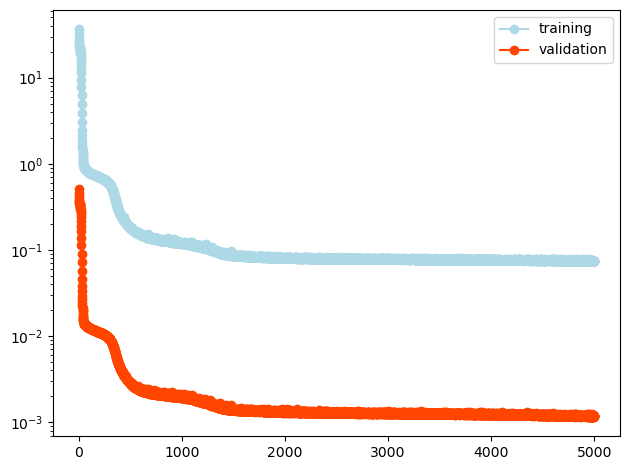

In [36]:
plt.figure()
plt.plot(track_train,'o-',color='lightblue',label='training')
plt.plot(track_val,'o-',color='orangered',label='validation')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
model.load_state_dict(torch.load('model_teacher.pt'), strict=False)
model_datapoints_z=model.encode_decode(model_datapoints)[0].detach().numpy()

training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)
model_datapoints_z=torch.Tensor(model_datapoints_z)

ANN_architecture=[3]
AutoEncoder_architecture=[9,3]

n_features=2
d_metric=3
n_neighbors=3
l=5e1

plumed_model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints_z,
                   act='Tanh',
                   z_lambda=l)

plumed_model.load_state_dict(torch.load('model_teacher.pt'), strict=False)

Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=9, bias=True)
  (1): Tanh()
  (2): Linear(in_features=9, out_features=3, bias=True)
  (3): Tanh()
  (4): Linear(in_features=3, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=9, bias=True)
  (3): Tanh()
  (4): Linear(in_features=9, out_features=2, bias=True)
)


<All keys matched successfully>

In [38]:
m=torch.jit.trace(plumed_model,torch.ones(1,n_features))
m.save('model_teacher.ptc')

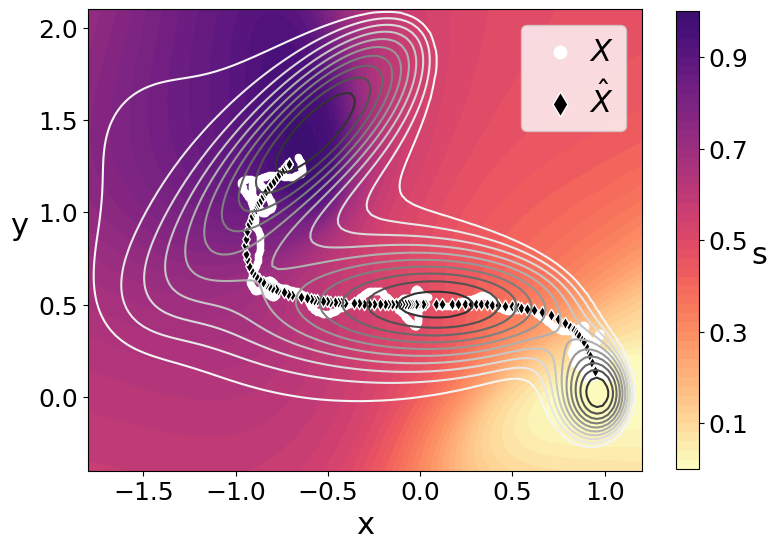

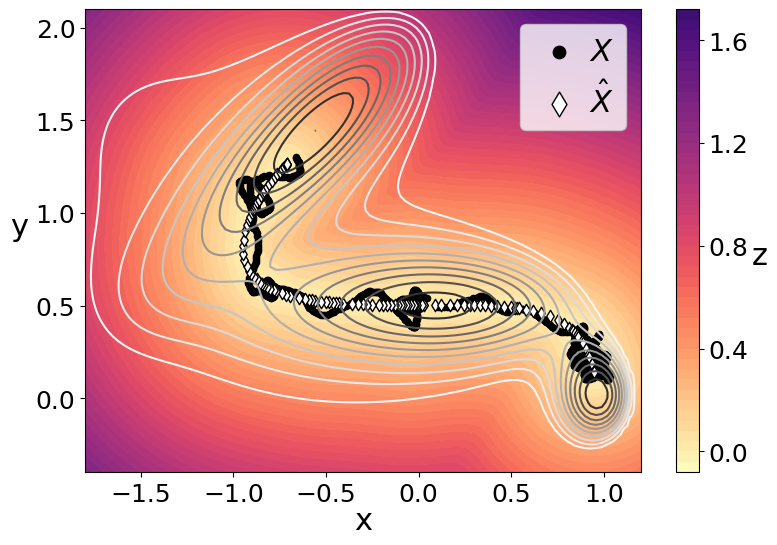

In [42]:
input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)
x_hat=x_hat.detach().numpy()

x_range = np.arange(-1.8, 1.2+0.01, 0.01)
y_range = np.arange(-0.4, 2.1+0.01, 0.01)

x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)

input=sample_grid
out=plumed_model(input)
s = out[:,0]
z = out[:,1]
s=s.detach().numpy()
z=z.detach().numpy()


grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_s = s.reshape(x_grid.shape)  
grid_z = z.reshape(x_grid.shape)  

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  


fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
contour2 = ax.contourf(grid_x,grid_y,grid_s,50,cmap=new_magma)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.scatter(training_datapoints.detach().numpy()[:,0], training_datapoints.detach().numpy()[:,1],color='white', s=20, marker='o',label=r'$X$')
plt.scatter(x_hat[:,0], x_hat[:,1],color='black', s=40, marker='d',edgecolors='white',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.87)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=22)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.arange(0.1, 1, 0.2))
cbar.update_ticks()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22)
plt.ylabel('y', rotation=0,fontsize=22, labelpad=14)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=22, markerscale=2, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
contour2 = ax.contourf(grid_x,grid_y,grid_z,50,cmap=new_magma)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

plt.scatter(training_datapoints.detach().numpy()[:,0], training_datapoints.detach().numpy()[:,1],color='black', s=20, marker='o',label=r'$X$')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=40, marker='d',edgecolors='black',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.87)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=22)
cbar.ax.tick_params(labelsize=18)
cbar.locator = ticker.MultipleLocator(base=0.4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22,labelpad=0)
plt.ylabel('y', rotation=0,fontsize=22,labelpad=12)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=22, markerscale=2, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

In [43]:
#reinforcement learning step
#perform a short OPES using PYTORCH DeepLNE

In [44]:
folder = 'OPES_reinforcement/'

Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"md_potential","w") as f:
    print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

with open(folder+"md_input","w") as f:
    print("""
nstep                   1000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        0,0.5
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

with open(folder+"plumed.dat","w") as f:
    print(f"""# vim:ft=plumed 
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

model: PYTORCH_MODEL FILE=model_teacher.ptc ARG=p.x,p.y

opes: OPES_METAD_EXPLORE ARG=model.node-0 BARRIER=30 PACE=200
uwall2: UPPER_WALLS ARG=model.node-1 KAPPA=1000 AT=+0.1 #+0.15


lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.5

DEBUG DETAILED_TIMERS

PRINT STRIDE=200 ARG=* FILE=COLVAR_Reinforcement
""",file=f)

In [45]:
!scp model_teacher.ptc OPES_reinforcement/

In [ ]:
#execute in shell
plumed ves_md_linearexpansion < md_input

5001


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


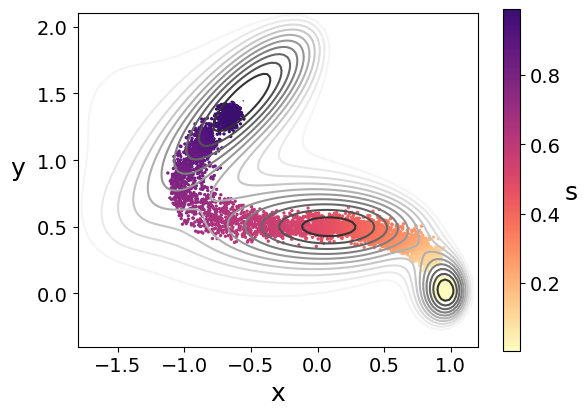

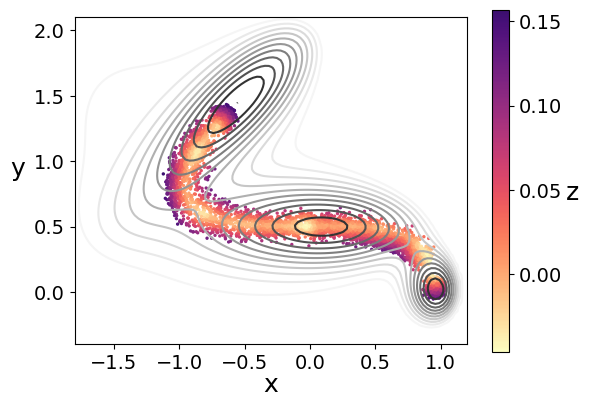

In [67]:
folder = 'OPES_reinforcement/'
colvar = plumed.read_as_pandas(folder+"COLVAR_Reinforcement")
print(len(colvar))

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  

fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model.node-0'],cmap=new_magma,s=2)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model.node-1'],cmap=new_magma,s=2)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18,labelpad=0)
plt.ylabel('y', rotation=0,fontsize=18,labelpad=12)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

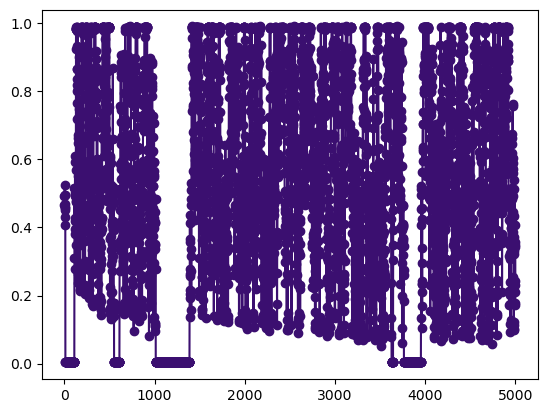

In [68]:
magma = plt.colormaps["magma_r"]
norm = mcolors.Normalize(vmin=0, vmax=10)

plt.plot(colvar['model.node-0'],'o-',color=magma(norm(8)))

In [69]:
reinforcement_data=colvar.iloc[:,1:3].to_numpy()

(500, 2)


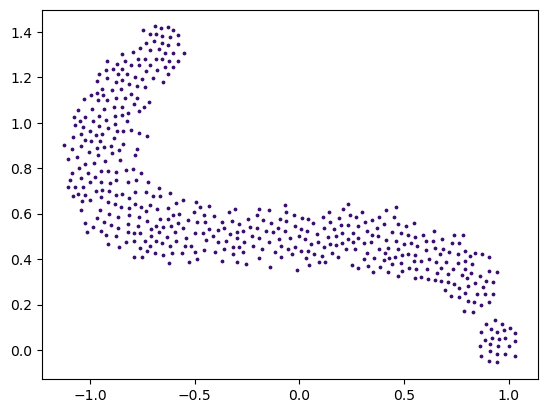

In [70]:
selector = FPS(n_to_select=500,initialize=0)

selector.fit(reinforcement_data.T)
reinforcement_data_FPS = selector.transform(reinforcement_data.T).T

print(reinforcement_data_FPS.shape)

plt.figure()
plt.scatter(reinforcement_data_FPS[:,0],reinforcement_data_FPS[:,1],color=magma(norm(8)),s=3,alpha=1)
plt.show()

In [71]:
student_training_datapoints=np.vstack((training_datapoints,reinforcement_data_FPS))
print(student_training_datapoints.shape)

(1603, 2)


Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=9, bias=True)
  (1): Tanh()
  (2): Linear(in_features=9, out_features=3, bias=True)
  (3): Tanh()
  (4): Linear(in_features=3, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=9, bias=True)
  (3): Tanh()
  (4): Linear(in_features=9, out_features=2, bias=True)
)


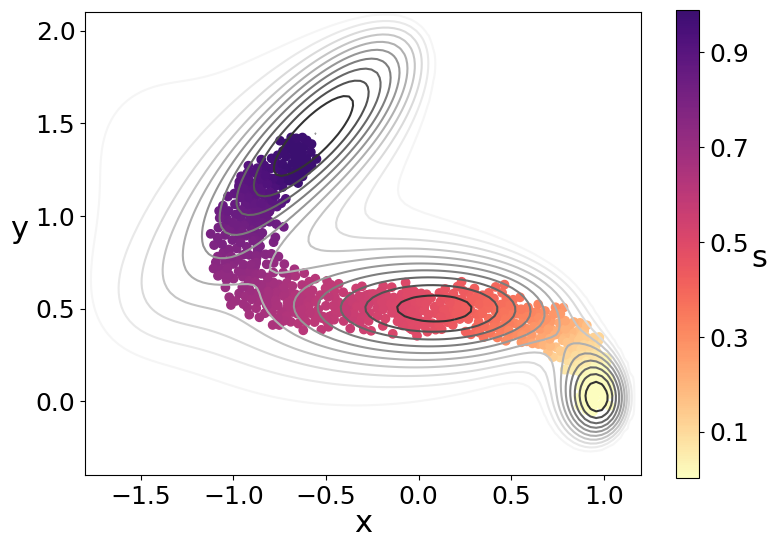

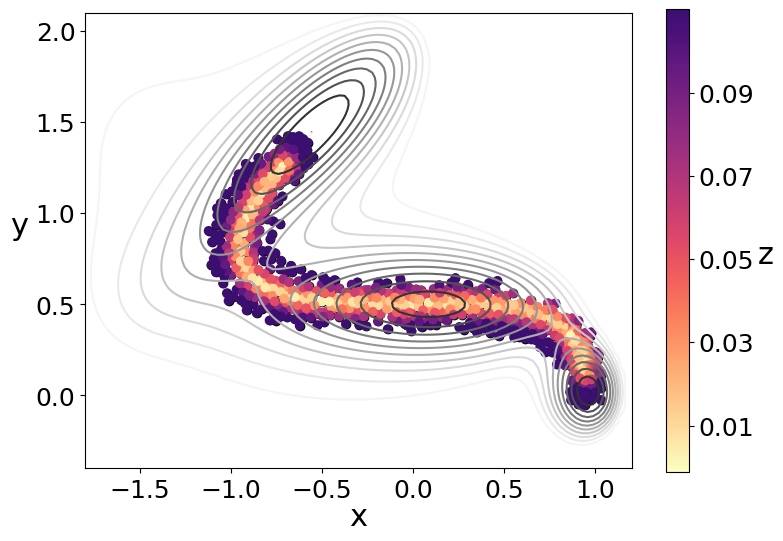

In [72]:
model.load_state_dict(torch.load('model_teacher.pt'), strict=False)
model_datapoints_z=model.encode_decode(model_datapoints)[0].detach().numpy()

training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)
model_datapoints_z=torch.Tensor(model_datapoints_z)

ANN_architecture=[3]
AutoEncoder_architecture=[9,3]

n_features=2
d_metric=3
n_neighbors=3
l=1e3

plumed_model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints_z,
                   act='Tanh',
                   z_lambda=l)

plumed_model.load_state_dict(torch.load('model_teacher.pt'), strict=False)



input_new=torch.Tensor(student_training_datapoints)

x_hat_new,s_new,d_new,dn_new = plumed_model.encode_decode(input_new)
x_hat_new=x_hat_new.detach().numpy()


out_new=plumed_model(input_new)
s_new = out_new[:,0]
z_new = out_new[:,1]
s_new=s_new.detach().numpy()
z_new=z_new.detach().numpy()

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256))) 


fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
plt.scatter(input_new[:,0],input_new[:,1],c=s_new,cmap=new_magma)
cbar = plt.colorbar(shrink=0.88)

cbar.set_label(r's', rotation=0, labelpad=8,fontsize=22)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.arange(0.1, 1.0, 0.2))
ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22,labelpad=0)
plt.ylabel('y', rotation=0,fontsize=22,labelpad=12)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

ndx_inf = np.where(np.isinf(z_new))
ndx_nan = np.where(np.isnan(z_new))

max_val = np.nanmax(z_new[np.isfinite(z_new)])

z_show=z_new
z_show[ndx_inf] = 0.11 
z_show[ndx_nan] = 0.11 

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
plt.scatter(input_new[:,0],input_new[:,1],c='k')
plt.scatter(input_new[:,0],input_new[:,1],c=z_show,cmap=new_magma)
cbar = plt.colorbar(shrink=0.87)
cbar.set_ticks(np.arange(0.01, 0.11, 0.02))
ax.contour(xv,yv,pot,10,cmap='Greys_r')

cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=22)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22,labelpad=0)
plt.ylabel('y', rotation=0,fontsize=22,labelpad=12)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [73]:
feature_data_student=torch.Tensor(student_training_datapoints)
label_data_student=torch.Tensor(z_new)

In [74]:
filtered_arr = label_data_student.detach().numpy()
filtered_arr = filtered_arr[filtered_arr != np.inf]
np.max(filtered_arr)

0.11

In [75]:
if torch.isnan(label_data_student).any() or torch.isinf(label_data_student).any():
    label_data_student[torch.isnan(label_data_student) | torch.isinf(label_data_student)] = 0.11

feature_data_student=feature_data_student.detach().numpy() 
label_data_student=label_data_student.detach().numpy() 

print(feature_data_student.shape)
print(label_data_student.shape)

(1603, 2)
(1603,)


In [76]:
feature_data_student=torch.tensor(feature_data_student, dtype=torch.float32)
label_data_student=torch.tensor(label_data_student, dtype=torch.float32)

dataset = TensorDataset(feature_data_student, label_data_student)


In [77]:
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)

train_size = int(0.8 * dataset_size)  
val_size = dataset_size - train_size
train_indices, val_indices = indices[:train_size], indices[train_size:]
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

batch_size_train = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

val_features = []
val_labels = []
for val_index in val_indices:
    feature, label = dataset[val_index]
    val_features.append(feature)
    val_labels.append(label)

val_features = torch.stack(val_features) 
val_labels = torch.stack(val_labels)  

val_features = val_features.to(device)
val_labels = val_labels.to(device)
val_features.shape

torch.Size([321, 2])

In [78]:
for batch_idx, (features, labels) in enumerate(train_loader):
    if batch_idx == 0 :
        print(features.shape)
        print(labels.shape)
batch_size_train*batch_idx

torch.Size([64, 2])
torch.Size([64])


1280

In [79]:
#train a student model on the DeepLNE

In [80]:
class DeepLNE_student(nn.Module):

    def __init__(self,
                ANN_layers: list,
                f: int,
                act: str):
        

        super(DeepLNE_student,self).__init__()
        
        # =======   LOSS  =======
        self.loss_mse = torch.nn.MSELoss()
        self.loss_smoothl1  =torch.nn.SmoothL1Loss(beta=1.35) 
        

        # ======= BLOCKS =======
        
        self.n_features=f
        
        print('Numer of input features:',self.n_features)
         
        if act == 'ReLU':
            self.activationf=torch.nn.ReLU()
        if act == 'Tanh':
            self.activationf=torch.nn.Tanh()
        if act == 'Sigmoid':
            self.activationf=torch.nn.Sigmoid()
        if act == 'ELU':
            self.activationf=torch.nn.ELU()
        if act == 'Softplus':    
            self.activationf=torch.nn.Softplus()
        
        self.ANNlayers = []
        
        self.ANNlayers.append(torch.nn.Linear(self.n_features, ANN_layers[0]))
        self.ANNlayers.append(self.activationf)
        
        for i in range(len(ANN_layers) - 1):
            self.ANNlayers.append(torch.nn.Linear(ANN_layers[i], ANN_layers[i + 1]))
            self.ANNlayers.append(self.activationf)

        self.ANNlayers.append(torch.nn.Linear(ANN_layers[-1], 1))
        
        
        self.ANN = torch.nn.Sequential(*self.ANNlayers)
        print('ANN architecture: ',self.ANN)
            
    
            
    def encode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.ANN(x)
        return x
       
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        out=self.encode(x)
        
        return out

In [81]:
device = torch.device("cuda")


ANN_architecture=[8,8,8] 

n_features=2

model_student_z = DeepLNE_student(ANN_layers=ANN_architecture,
                   f=n_features,
                   act='Tanh').to(device)


optimizer = optim.Adam(model_student_z.parameters(), lr=0.001)

Numer of input features: 2
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): Tanh()
  (6): Linear(in_features=8, out_features=1, bias=True)
)


In [82]:
model_student_z = model_student_z.to('cuda')

track_train = []
track_val = []
best_val_loss = float('inf') 

num_epochs = 15001
for epoch in range(num_epochs):
    train_loss = 0.0
    model_student_z.train()  
    for batch_idx, (features, labels) in enumerate(train_loader):
        x = features.to(device)  
        y = labels.to(device) 
        
        out_student = model_student_z.forward(x).flatten()
        
        loss =model_student_z.loss_smoothl1(out_student, y)
        
        #L2 regularization
        for param in model.parameters():
            loss += 1e-4 * torch.norm(param, 2)
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / batch_idx
    track_train.append(train_loss)
    
    # Validation phase
    model_student_z.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        
        val_x = val_features.to(device)
        val_y = val_labels.to(device)

        val_out_student = model_student_z.forward(val_x).flatten()

        loss =model_student_z.loss_smoothl1(val_out_student, val_y)
        
        
    val_loss += loss.item() * val_x.size(0)

    track_val.append(val_loss)
    
    if epoch % 100 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_student_z.state_dict(), 'model_params_student_z.pt')

Epoch: 0 	Training Loss: 1.681894 	Validation Loss: 2.995117
Epoch: 100 	Training Loss: 0.250433 	Validation Loss: 0.117101
Epoch: 200 	Training Loss: 0.250385 	Validation Loss: 0.118174
Epoch: 300 	Training Loss: 0.250239 	Validation Loss: 0.116208
Epoch: 400 	Training Loss: 0.250405 	Validation Loss: 0.117498
Epoch: 500 	Training Loss: 0.250294 	Validation Loss: 0.114795
Epoch: 600 	Training Loss: 0.249732 	Validation Loss: 0.124623
Epoch: 700 	Training Loss: 0.249514 	Validation Loss: 0.108867
Epoch: 800 	Training Loss: 0.249098 	Validation Loss: 0.112587
Epoch: 900 	Training Loss: 0.249076 	Validation Loss: 0.115918
Epoch: 1000 	Training Loss: 0.249420 	Validation Loss: 0.106999
Epoch: 1100 	Training Loss: 0.249013 	Validation Loss: 0.102449
Epoch: 1200 	Training Loss: 0.248374 	Validation Loss: 0.105649
Epoch: 1300 	Training Loss: 0.248447 	Validation Loss: 0.099451
Epoch: 1400 	Training Loss: 0.249162 	Validation Loss: 0.096639
Epoch: 1500 	Training Loss: 0.248156 	Validation Los

Epoch: 12800 	Training Loss: 0.226690 	Validation Loss: 0.002468
Epoch: 12900 	Training Loss: 0.226686 	Validation Loss: 0.002592
Epoch: 13000 	Training Loss: 0.226743 	Validation Loss: 0.002706
Epoch: 13100 	Training Loss: 0.226705 	Validation Loss: 0.002570
Epoch: 13200 	Training Loss: 0.226724 	Validation Loss: 0.002669
Epoch: 13300 	Training Loss: 0.226718 	Validation Loss: 0.002487
Epoch: 13400 	Training Loss: 0.226689 	Validation Loss: 0.002648
Epoch: 13500 	Training Loss: 0.226677 	Validation Loss: 0.002545
Epoch: 13600 	Training Loss: 0.226681 	Validation Loss: 0.002543
Epoch: 13700 	Training Loss: 0.226710 	Validation Loss: 0.002663
Epoch: 13800 	Training Loss: 0.226678 	Validation Loss: 0.002562
Epoch: 13900 	Training Loss: 0.226702 	Validation Loss: 0.002585
Epoch: 14000 	Training Loss: 0.226660 	Validation Loss: 0.002311
Epoch: 14100 	Training Loss: 0.226684 	Validation Loss: 0.002445
Epoch: 14200 	Training Loss: 0.226655 	Validation Loss: 0.002339
Epoch: 14300 	Training Lo

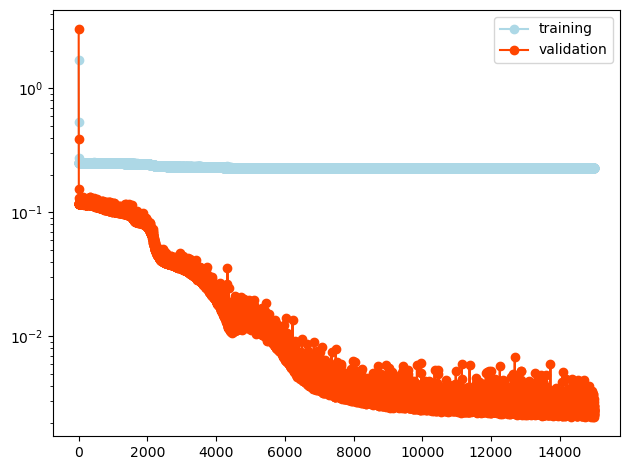

In [84]:
plt.figure()
plt.plot(track_train,'o-',color='lightblue',label='training')
plt.plot(track_val,'o-',color='orangered',label='validation')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
model_student_z=model_student_z.cpu()

In [86]:
model_student_z.load_state_dict(torch.load('model_params_student_z.pt'), strict=False)

plumed_model_student_z = DeepLNE_student(ANN_layers=ANN_architecture,
                   f=n_features,
                   act='Tanh')

plumed_model_student_z.load_state_dict(torch.load('model_params_student_z.pt'), strict=False)

Numer of input features: 2
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): Tanh()
  (6): Linear(in_features=8, out_features=1, bias=True)
)


<All keys matched successfully>

In [87]:
m=torch.jit.trace(plumed_model_student_z,torch.ones(1,n_features))
m.save('model_student_z.ptc')

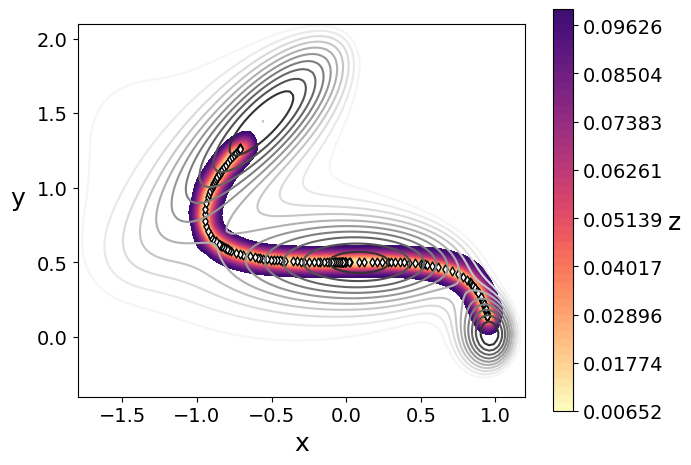

In [88]:
magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256))) 

x_range = np.arange(-1.8, 1.2, 0.01)
y_range = np.arange(-0.4, 2.1, 0.01)

x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)

input=sample_grid
out=plumed_model_student_z(input)
z = out[:,0]
z=z.detach().numpy()


grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_z = z.reshape(x_grid.shape)  

x=training_datapoints

fig, ax = plt.subplots(1, figsize=(7,7))
levels=np.linspace(np.min(grid_z), np.max(grid_z), 51)
levels=np.linspace(np.min(grid_z), 0.1, 51)
contour2 = ax.contourf(grid_x,grid_y,grid_z,levels,cmap=new_magma)

ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=20, marker='d',edgecolors='black',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [89]:
#s

In [90]:
feature_data_student=torch.Tensor(student_training_datapoints)
label_data_student=torch.Tensor(s_new)

In [91]:
feature_data_student=feature_data_student.detach().numpy() 
label_data_student=label_data_student.detach().numpy() 

print(feature_data_student.shape)
print(label_data_student.shape)

(1603, 2)
(1603,)


In [92]:
feature_data_student=torch.tensor(feature_data_student, dtype=torch.float32)
label_data_student=torch.tensor(label_data_student, dtype=torch.float32)

dataset = TensorDataset(feature_data_student, label_data_student)


In [93]:
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)

train_size = int(0.8 * dataset_size)  
val_size = dataset_size - train_size
train_indices, val_indices = indices[:train_size], indices[train_size:]
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

batch_size_train = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

val_features = []
val_labels = []
for val_index in val_indices:
    feature, label = dataset[val_index]
    val_features.append(feature)
    val_labels.append(label)

val_features = torch.stack(val_features)  
val_labels = torch.stack(val_labels)  

val_features = val_features.to(device)
val_labels = val_labels.to(device)
val_features.shape

torch.Size([321, 2])

In [94]:
for batch_idx, (features, labels) in enumerate(train_loader):
    if batch_idx == 0 :
        print(features.shape)
        print(labels.shape)
batch_size_train*batch_idx

torch.Size([64, 2])
torch.Size([64])


1280

In [95]:
ANN_architecture=[8,8,8]

n_features=2

model_student_s = DeepLNE_student(ANN_layers=ANN_architecture,
                   f=n_features,
                   act='Tanh')

device = torch.device("cpu")
optimizer = optim.Adam(model_student_s.parameters(), lr=0.001)

Numer of input features: 2
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): Tanh()
  (6): Linear(in_features=8, out_features=1, bias=True)
)


In [97]:
track_train = []
track_val = []
best_val_loss = float('inf')  

num_epochs = 5001
for epoch in range(num_epochs):
    train_loss = 0.0
    model_student_z.train()  
    for batch_idx, (features, labels) in enumerate(train_loader):
        x = features.to(device)  
        y = labels.to(device) 
        
        out_student = model_student_s.forward(x).flatten()
        
        loss =model_student_s.loss_mse(out_student, y)
        
        #L2 regularization
        for param in model.parameters():
            loss += 1e-4 * torch.norm(param, 2)
            
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / batch_idx
    track_train.append(train_loss)
    
    # Validation phase
    model_student_z.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        
        val_x = val_features.to(device)
        val_y = val_labels.to(device)

        val_out_student = model_student_s.forward(val_x).flatten()

        loss =model_student_s.loss_mse(val_out_student, val_y)
        
        
    val_loss += loss.item() * val_x.size(0)

    track_val.append(val_loss)
    
    if epoch % 100 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_student_s.state_dict(), 'model_params_student_s.pt')


Epoch: 0 	Training Loss: 3.183668 	Validation Loss: 8.678310
Epoch: 100 	Training Loss: 0.263454 	Validation Loss: 0.189976
Epoch: 200 	Training Loss: 0.260424 	Validation Loss: 0.172303
Epoch: 300 	Training Loss: 0.261842 	Validation Loss: 0.198917
Epoch: 400 	Training Loss: 0.257109 	Validation Loss: 0.158681
Epoch: 500 	Training Loss: 0.255946 	Validation Loss: 0.152011
Epoch: 600 	Training Loss: 0.255735 	Validation Loss: 0.145002
Epoch: 700 	Training Loss: 0.254092 	Validation Loss: 0.161771
Epoch: 800 	Training Loss: 0.252568 	Validation Loss: 0.136398
Epoch: 900 	Training Loss: 0.249228 	Validation Loss: 0.125662
Epoch: 1000 	Training Loss: 0.247746 	Validation Loss: 0.118010
Epoch: 1100 	Training Loss: 0.247166 	Validation Loss: 0.094806
Epoch: 1200 	Training Loss: 0.244514 	Validation Loss: 0.103341
Epoch: 1300 	Training Loss: 0.245602 	Validation Loss: 0.099940
Epoch: 1400 	Training Loss: 0.242641 	Validation Loss: 0.084494
Epoch: 1500 	Training Loss: 0.239899 	Validation Los

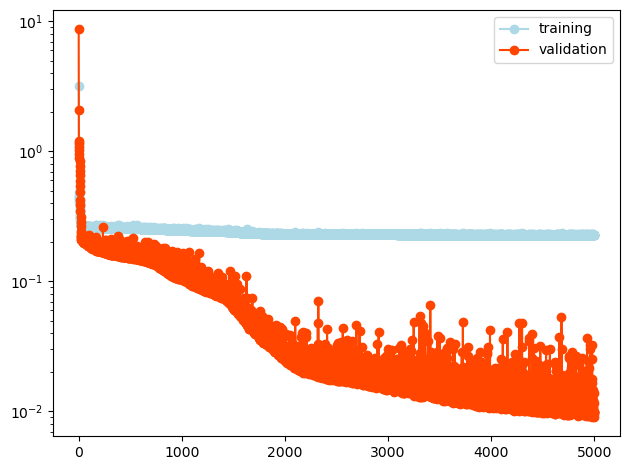

In [98]:
plt.figure()
plt.plot(track_train,'o-',color='lightblue',label='training')
plt.plot(track_val,'o-',color='orangered',label='validation')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
model_student_s.load_state_dict(torch.load('model_params_student_s.pt'), strict=False)

plumed_model_student_s = DeepLNE_student(ANN_layers=ANN_architecture,
                   f=n_features,
                   act='Tanh')

plumed_model_student_s.load_state_dict(torch.load('model_params_student_s.pt'), strict=False)

Numer of input features: 2
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): Tanh()
  (6): Linear(in_features=8, out_features=1, bias=True)
)


<All keys matched successfully>

In [100]:
m=torch.jit.trace(plumed_model_student_s,torch.ones(1,n_features))
m.save('model_student_s.ptc')

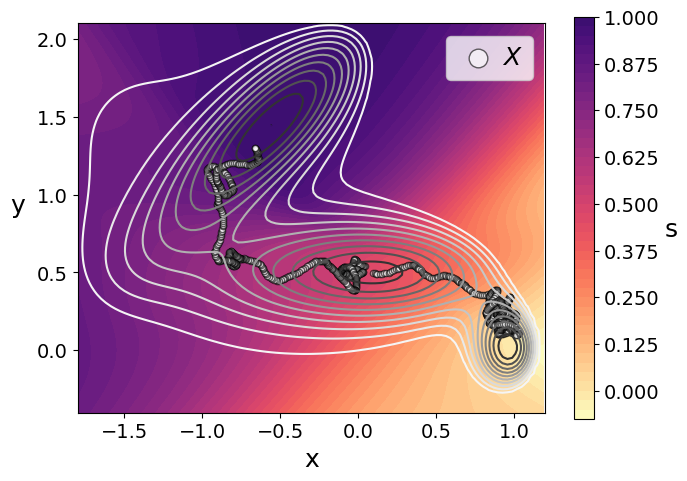

In [101]:
magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256))) 

x_range = np.arange(-1.8, 1.2, 0.01)
y_range = np.arange(-0.4, 2.1, 0.01)

x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)

input=sample_grid
out=plumed_model_student_s(input)
s = out
s=s.detach().numpy()


grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_s = s.reshape(x_grid.shape)  

x=training_datapoints

fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_s,50,cmap=new_magma)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.scatter(x[:,0], x[:,1],color='white', s=20, alpha=0.6,edgecolors='black',label=r'$X$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

In [102]:
#we have 2 student models, 1 learning s and one learning z
#now we export them into PLUMED

In [161]:
def dumpPlumed(filename, model, activation='tanh'):
    # Extract weights and biases from the model
    weights = [param.detach().numpy().T for param in model.parameters() if len(param.size()) == 2]
    biases = [param.detach().numpy() for param in model.parameters() if len(param.size()) == 1]

    # Flatten and concatenate weights and biases
    par = np.hstack([param.flatten() for param in weights + biases])

    # Reshape weights and biases according to the original shapes
    n = 0
    for i in range(len(weights)):
        weights[i] = np.reshape(par[n:n+np.prod(weights[i].shape)], weights[i].shape)
        n += np.prod(weights[i].shape)
    for i in range(len(biases)):
        biases[i] = np.reshape(par[n:n+np.prod(biases[i].shape)], biases[i].shape)
        n += np.prod(biases[i].shape)

    # Write weights, biases, and activations to the file
    with open(filename, "w") as f:
        for i in range(len(weights)):
            ni, no = weights[i].shape
            print("#! FIELDS " + " ".join(["w"+str(j) for j in range(ni)]), file=f)
            for j in range(no):
                print(' '.join(map(str, weights[i][:,j])), file=f)
            print("#! FIELDS " + " ".join(["b"+str(j) for j in range(no)]), file=f)
            print(' '.join(map(str, biases[i])), file=f)
            if i+1 < len(weights):
                print("#! FIELDS " + " ".join(["activation"+str(j) for j in range(no)]), file=f)
                print(' '.join([activation]*no), file=f)

In [162]:
dumpPlumed('ann_multi_s.dat', model_student_s, 'tanh')

In [163]:
dumpPlumed('ann_multi_z.dat', model_student_z, 'tanh')

In [169]:
folder = 'OPES/'

Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"md_potential","w") as f:
    print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

with open(folder+"md_input","w") as f:
    print("""
nstep                   10000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        0,0.5
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

with open(folder+"plumed.dat","w") as f:
    print(f"""# vim:ft=plumed 
LOAD FILE=MultiANN_tanh.so
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

model_s: MULTI_ANN ARG=p.x,p.y PARAMETERS=ann_multi_s.dat groupby=2
model_z: MULTI_ANN ARG=p.x,p.y PARAMETERS=ann_multi_z.dat groupby=2

opes: OPES_METAD ARG=model_s BARRIER=15 PACE=200
#opes: OPES_METAD ARG=model_s,model_z BARRIER=15 SIGMA=0.02,0.02 PACE=200

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.5
uwall2: UPPER_WALLS ARG=model_z KAPPA=2000 AT=0.1

DEBUG DETAILED_TIMERS

PRINT STRIDE=200 ARG=* FILE=COLVAR_DeepLNE
""",file=f)

In [170]:
#create MultiANN CV with tanh activation function
#redirect the PATH for all #include to your PLUMED directory

In [171]:
%%bash 
cat > MultiANN_tanh.cpp << EOF
/* +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
   Copyright (c) 2011-2021 The plumed team
   (see the PEOPLE file at the root of the distribution for a list of names)

   See http://www.plumed.org for more information.

   This file is part of plumed, version 2.

   plumed is free software: you can redistribute it and/or modify
   it under the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.

   plumed is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; without even the implied warranty of
   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
   GNU Lesser General Public License for more details.

   You should have received a copy of the GNU Lesser General Public License
   along with plumed.  If not, see <http://www.gnu.org/licenses/>.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ */
#include "/home/rizziv@farma.unige.ch/plumed2-2.9/src/function/Function.h"
#include "/home/rizziv@farma.unige.ch/plumed2-2.9/src/function/ActionRegister.h"
#include "/home/rizziv@farma.unige.ch/plumed2-2.9/src/tools/IFile.h"
#include "/home/rizziv@farma.unige.ch/plumed2-2.9/src/tools/Matrix.h"

#include <cmath>
#include <algorithm>

using namespace std;

namespace PLMD {
namespace function {

class MultiANN :
  public Function
{
  enum class Activation {
    Softplus, 
    Tanh
  };
  unsigned groupby;
  // weights
  std::vector<Matrix<double>> weights;
  // transpose matrices (this is to avoid taking the transpose in calculate()
  std::vector<Matrix<double>> weights_transposed;
  // biases
  std::vector<std::vector<double>> biases;
  // activation functions (custom for each node of each layer)
  std::vector<std::vector<Activation>> activation;
  // value of each layer
  std::vector<Matrix<double>> layers;
  // derivative of result wrt values at each layer
  std::vector<Matrix<double>> dlayers;
  // derivative of the activation function (stored in the forward loop for efficienty)
  std::vector<Matrix<double>> dactivation;
public:
  explicit MultiANN(const ActionOptions&);
  void calculate() override;
  static void registerKeywords(Keywords& keys);
};


PLUMED_REGISTER_ACTION(MultiANN,"MULTI_ANN")

void MultiANN::registerKeywords(Keywords& keys) {
  Function::registerKeywords(keys);
  keys.use("ARG");
  keys.add("compulsory","PARAMETERS","ANN.dat","parameter file");
  keys.add("compulsory","GROUPBY","1","groups");
}

MultiANN::MultiANN(const ActionOptions&ao):
  Action(ao),
  Function(ao)
{
  groupby=1;
  parse("GROUPBY",groupby);
  log<<"  groupby: "<<groupby<<"\n";
  plumed_assert(getNumberOfArguments()%groupby==0);
  std::string parfile="";
  parse("PARAMETERS",parfile);
  log<<"  parameters file: "<<parfile<<"\n";
  plumed_assert(parfile.length()>0);
  IFile ifile;
  ifile.link(*this);
  ifile.open(parfile);
  unsigned previous_layer=groupby;
  layers.push_back(Matrix<double>(getNumberOfArguments()/groupby,groupby));
  dlayers.push_back(Matrix<double>(getNumberOfArguments()/groupby,groupby));
  dactivation.push_back(Matrix<double>(getNumberOfArguments()/groupby,groupby));
  while(true) { // layers
    std::vector<std::vector<double>> weights_rows;
    log<<"  weights:\n";
    while(true) { // weights
      std::vector<double> weights_row;
      if(!ifile.FieldExist("w0")) break;
      log<<"  *";
      for(unsigned i=0; i<previous_layer; i++) {
        std::string item;
        Tools::convert(i,item);
        item="w"+item;
        double w=0.0;
        ifile.scanField(item,w);
        weights_row.push_back(w);
        log<<" "<<w;
      }
      log<<"\n";
      ifile.scanField(); // end of line
      if(weights_rows.size()>1) plumed_assert(weights_rows[0].size()==weights_row.size());
      weights_rows.push_back(weights_row);
    }
    plumed_assert(weights_rows.size()>0);
    auto neww=Matrix<double>(weights_rows[0].size(),weights_rows.size());
    for(unsigned i=0; i<weights_rows.size(); i++) {
      for(unsigned j=0; j<weights_rows[0].size(); j++) {
        neww(j,i)=weights_rows[i][j];
      }
    }
    weights.push_back(neww);
    previous_layer=weights_rows.size();
    std::vector<double> biases_row;
    plumed_assert(ifile.FieldExist("b0"));
    log<< "  biases: ";
    for(unsigned i=0; i<previous_layer; i++) {
      std::string item;
      Tools::convert(i,item);
      item="b"+item;
      double b=0.0;
      ifile.scanField(item,b);
      log<<" "<<b;
      biases_row.push_back(b);
    }
    log<<"\n";
    ifile.scanField(); // end of line;
    biases.push_back(biases_row);
    std::vector<Activation> activation_row;
    if(!ifile.FieldExist("activation0")) break;
    log<<"  activation:";
    for(unsigned i=0; i<previous_layer; i++) {
      std::string item;
      Tools::convert(i,item);
      item="activation"+item;
      std::string a;
      if(!ifile.scanField(item,a)) break;
      Activation aa;
      if(a=="softplus") {
        aa=Activation::Softplus;
      } else if (a == "tanh") {
        aa = Activation::Tanh;
      } else {
        plumed_error();
      }
      log<<" "<<a;
      activation_row.push_back(aa);
    }
    log<<"\n";
    ifile.scanField(); // end of line;
    plumed_assert(activation_row.size()==previous_layer);
    activation.push_back(activation_row);
  }

  for(unsigned i=0; i<weights.size(); i++) {
    layers.push_back(Matrix<double>(getNumberOfArguments()/groupby,weights[i].ncols()));
    dlayers.push_back(Matrix<double>(getNumberOfArguments()/groupby,weights[i].ncols()));
    dactivation.push_back(Matrix<double>(getNumberOfArguments()/groupby,weights[i].ncols()));
    Matrix<double> tw;
    transpose(weights[i],tw);
    weights_transposed.push_back(tw);
  }

  addValueWithDerivatives();
  getPntrToComponent(0)->setNotPeriodic();
  checkRead();

}

void MultiANN::calculate() {

  // init
  for(unsigned i=0; i<getNumberOfArguments(); i++) {
    layers[0](i/groupby,i%groupby)=getArgument(i);
  }

  // forward loop
  for(unsigned i=0; i<weights.size(); i++) {

    mult(layers[i],weights[i],layers[i+1]);

    for(unsigned j=0; j<layers[i+1].nrows(); j++) {
      for(unsigned k=0; k<layers[i+1].ncols(); k++) {
        layers[i+1](j,k)+=biases[i][k];
      }
    }
    if(i<weights.size()-1) {
      for(unsigned k=0; k<layers[i+1].ncols(); k++) {
        switch(activation[i][k]) {
        case Activation::Softplus:
        {
          // compute both activation and dactivation, to save on the exponential
          for(unsigned j=0; j<layers[i+1].nrows(); j++) {
            auto x=layers[i+1](j,k);
            auto expabsx=std::exp(-std::abs(x));
            auto y=std::log1p(expabsx) + std::max(x,0.0);
            auto dy=0.0;
            if(x>=0) dy=1.0/(1.0+expabsx);
            else     dy=expabsx/(1.0+expabsx);
            layers[i+1](j,k)=y;
            dactivation[i+1](j,k)=dy;
          }
          break;
        }
        case Activation::Tanh:
        {
            // compute both activation and dactivation using tanh and its derivative
            for(unsigned j=0; j<layers[i+1].nrows(); j++) {
                auto x = layers[i+1](j,k);
                auto y = std::tanh(x);
                auto dy = 1.0 - y*y; // tanh derivative: 1 - tanh^2(x)
                layers[i+1](j,k) = y;
                dactivation[i+1](j,k) = dy;
            }
            break;
        }
        default:
          plumed_error();
        }
      }
    }
  }
  double combine=0.0;
  for(unsigned i=0; i<layers[layers.size()-1].nrows(); i++) combine+=layers[layers.size()-1](i,0);


  // init
  for(unsigned i=0; i<layers[layers.size()-1].nrows(); i++) dlayers[layers.size()-1](i,0)=1.0;

  // backward loop
  for(unsigned i=layers.size()-1; i>0; i--) {
    if(i<layers.size()-1) {
      for(unsigned k=0; k<dlayers[i].nrows(); k++) for(unsigned l=0; l<dlayers[i].ncols(); l++)
          dlayers[i](k,l)*=dactivation[i](k,l);
    }
    mult(dlayers[i],weights_transposed[i-1],dlayers[i-1]);
  }

  setValue(combine);
  for(unsigned i=0; i<getNumberOfArguments(); i++) {
    setDerivative(i,dlayers[0](i/groupby,i%groupby));
  }

}

}
}


EOF

In [172]:
!scp MultiANN_tanh.so OPES/
!scp ann_multi_s.dat OPES/
!scp ann_multi_z.dat OPES/

In [ ]:
#has to be executed outside conda environments
time plumed ves_md_linearexpansion < md_input

In [697]:
!find . -type f -name "#*" -exec rm -rf {} +
!find . -type f -name "bck*" -exec rm -rf {} +

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


50001


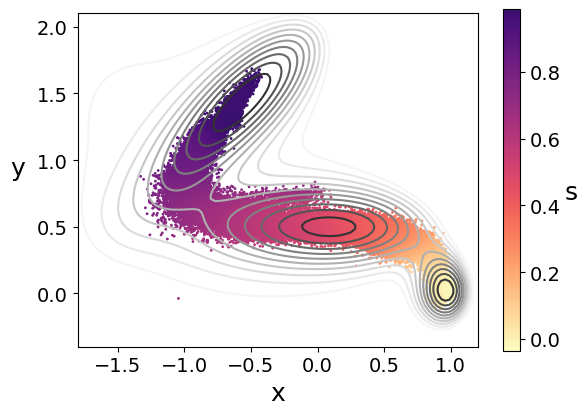

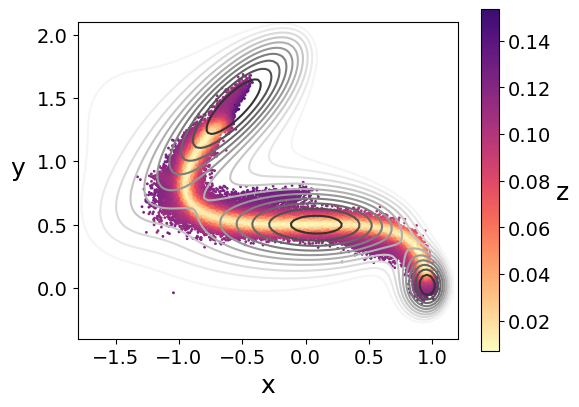

In [175]:
magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256))) 

colvar = plumed.read_as_pandas("OPES/COLVAR_DeepLNE")
print(len(colvar))

fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model_s'],cmap=new_magma,s=1)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# plot pot isolines + samples
fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model_z'],cmap=new_magma,s=1)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [176]:
#reweighting the FES close to Xhat
colvar = plumed.read_as_pandas("OPES/COLVAR_DeepLNE")
colvar

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


,time,p.x,p.y,p.z,ene,pot.bias,pot.ene_bias,model_s,model_z,opes.bias,opes.rct,opes.zed,opes.neff,opes.nker,lwall.bias,lwall.force2,uwall.bias,uwall.force2,uwall2.bias,uwall2.force2
0,0.0,0.000000,0.500000,0.0,1.503381,1.503381,1.503381,0.489166,0.009705,-15.000000,-15.000000,1.000000,1.000001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,1.0,0.109336,0.559521,0.0,2.143458,2.143458,2.143458,0.456254,0.055146,-15.000000,-15.000000,1.000000,1.000001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2.0,0.095264,0.479743,0.0,1.360214,1.360214,1.360214,0.470809,0.021754,-15.000000,-15.000000,1.000000,1.000001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,3.0,-0.191347,0.613388,0.0,6.034613,6.034613,6.034613,0.535459,0.102563,-15.000000,-15.000000,1.000000,1.000001,0.0,0.0,0.0,0.0,0.0,0.013133,105.066597
4,4.0,-0.016803,0.442057,0.0,2.439631,2.439631,2.439631,0.496210,0.063484,-15.000000,-15.000000,1.000000,1.000001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996.0,-0.116477,0.413362,0.0,4.226381,4.226381,4.226381,0.513214,0.089307,0.453781,0.498532,0.078543,10081.954269,54.0,0.0,0.0,0.0,0.0,0.000000,0.000000
49997,49997.0,-0.569014,0.504961,0.0,10.484728,10.484728,10.484728,0.604440,0.020762,-6.233911,0.498512,0.078543,10081.954750,54.0,0.0,0.0,0.0,0.0,0.000000,0.000000
49998,49998.0,-0.843202,0.718009,0.0,14.757284,14.757284,14.757284,0.714633,0.075083,-10.428841,0.498492,0.078543,10081.954757,54.0,0.0,0.0,0.0,0.0,0.000000,0.000000
49999,49999.0,-0.002671,0.509855,0.0,1.538039,1.538039,1.538039,0.488146,0.010625,1.206710,0.498513,0.078543,10082.606048,54.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [177]:
colvar = plumed.read_as_pandas("OPES/COLVAR_DeepLNE")

cutoff_value = 0.08 # Define your cutoff value here
filtered_df = colvar.loc[colvar['model_z'] <= cutoff_value]
filtered_df = filtered_df.reset_index(drop=True)

plumed.write_pandas(filtered_df,"OPES/COLVAR_DeepLNE_reweight")

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


In [178]:
!python FES_from_Reweighting.py --colvar ./OPES/COLVAR_DeepLNE_reweight --kt 1 --cv model_s --sigma 0.04 --bin 150 --blocks 10 --bias opes.bias --outfile fes-rew-DeepLNE.dat


 using cv "model_s" found at column 8
 using bias "opes.bias" found at column 10
 printing 10 FES files, one every 3355 samples
 first 5 samples discarded to fit with given stride
+++ IMPORTANT: remember to try different numbers of blocks and check for the convergence of the uncertainty estimate +++
 printing final FES with block average to fes-rew-DeepLNE.dat
 number of blocks is 10, while effective number is 9.70795
 average FES uncertainty is: 0.056040512087038336
                              


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


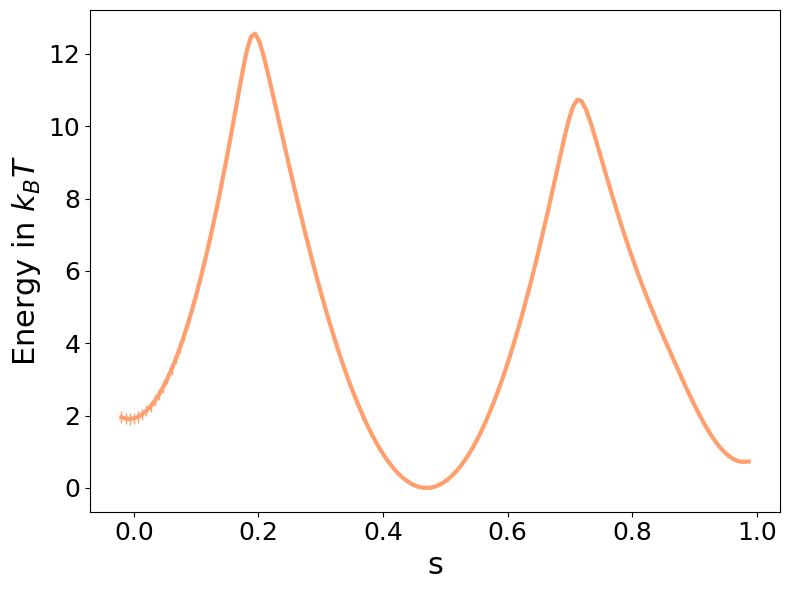

In [204]:
import plumed

data=plumed.read_as_pandas("fes-rew-DeepLNE.dat" )

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
plt.errorbar(data['model_s'], data['file.free'], yerr=data['uncertainty'], color=magma(norm(2)),linewidth=1)
plt.plot(data['model_s'], data['file.free'], color=magma(norm(2)),linewidth=3)
plt.ylabel(r'Energy in $k_BT$', fontsize=22)
plt.xlabel('s',fontsize=22)

plt.tick_params(axis='y')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()

In [182]:
folder = 'OPES_referenceFES/'

Path(folder).mkdir(parents=True, exist_ok=True)

# md_potential for ves_md_linearexpansion (actual potential is in plumed.dat)
with open(folder+"md_potential","w") as f:
    print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

# md_input for ves_md_linearexpansion
with open(folder+"md_input","w") as f:
    print("""
nstep                   10000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        0,0.5
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

with open(folder+"plumed.dat","w") as f:
    print(f"""# vim:ft=plumed 
LOAD FILE=MultiANN_tanh.so
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

model_s: MULTI_ANN ARG=p.x,p.y PARAMETERS=ann_multi_s.dat groupby=2
model_z: MULTI_ANN ARG=p.x,p.y PARAMETERS=ann_multi_z.dat groupby=2

opes: OPES_METAD ARG=p.x,p.y BARRIER=15 PACE=200

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.5

DEBUG DETAILED_TIMERS

PRINT STRIDE=200 ARG=* FILE=COLVAR_DeepLNE
""",file=f)

In [181]:
!scp MultiANN_tanh.so OPES_referenceFES/
!scp ann_multi_s.dat OPES_referenceFES/
!scp ann_multi_z.dat OPES_referenceFES/

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


50001


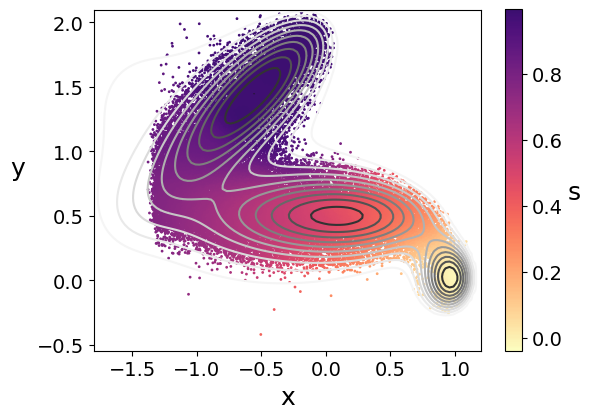

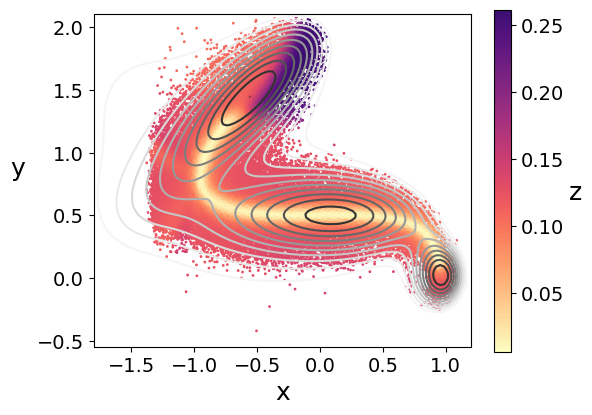

In [186]:
magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256))) 

colvar = plumed.read_as_pandas("OPES_referenceFES/COLVAR_DeepLNE")
print(len(colvar))

fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model_s'],cmap=new_magma,s=1)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# plot pot isolines + samples
fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model_z'],cmap=new_magma,s=1)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [187]:
colvar = plumed.read_as_pandas("OPES_referenceFES/COLVAR_DeepLNE")

cutoff_value = 0.08 # Define your cutoff value here
filtered_df = colvar.loc[colvar['model_z'] <= cutoff_value]
filtered_df = filtered_df.reset_index(drop=True)

plumed.write_pandas(filtered_df,"OPES_referenceFES/COLVAR_reference_reweight")

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


In [188]:
!python FES_from_Reweighting.py --colvar ./OPES_referenceFES/COLVAR_reference_reweight --kt 1 --cv model_s --sigma 0.04 --bin 150 --blocks 10 --bias opes.bias --outfile fes-rew-reference.dat


 using cv "model_s" found at column 8
 using bias "opes.bias" found at column 10
 printing 10 FES files, one every 1600 samples
 first 7 samples discarded to fit with given stride
+++ IMPORTANT: remember to try different numbers of blocks and check for the convergence of the uncertainty estimate +++
 printing final FES with block average to fes-rew-reference.dat
 number of blocks is 10, while effective number is 9.65934
 average FES uncertainty is: 0.028955590551128296
                              


12.559659 12.653493


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt

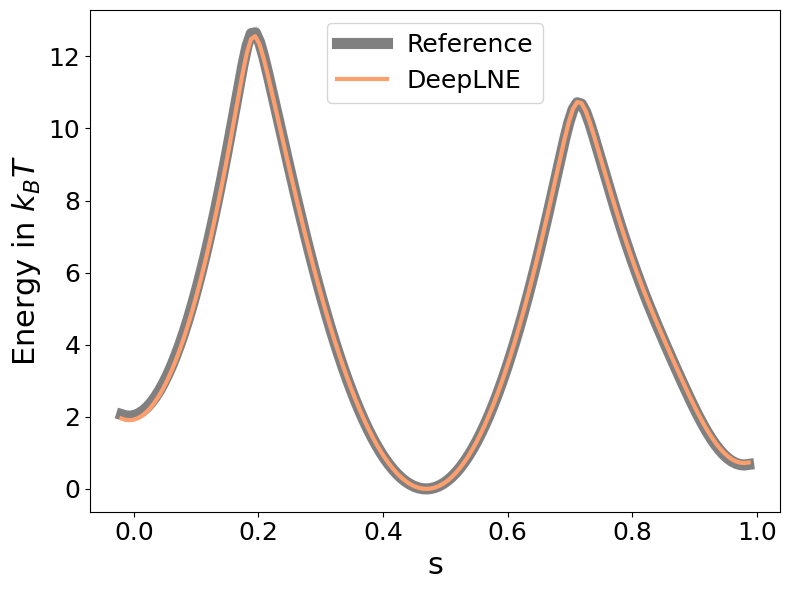

In [196]:
magma = plt.colormaps["magma_r"]
norm = mcolors.Normalize(vmin=0, vmax=10)

DeepLNEc=magma(norm(2))
refc=magma(norm(10))

data1=plumed.read_as_pandas("fes-rew-DeepLNE.dat" )
data=plumed.read_as_pandas("fes-rew-reference.dat" )

print(np.max(data1['file.free']),np.max(data['file.free']))

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
#plt.errorbar(data['model_s'], data['file.free'], yerr=data['uncertainty'], color=refc,linewidth=1)
#plt.plot(data['model_s'], data['file.free'], color=refc,linewidth=8,alpha=0.5,label='reference')
plt.plot(data['model_s'], data['file.free'], color='gray',linewidth=8,alpha=1,label='Reference')
#plt.errorbar(data1['model_s'], data1['file.free'], yerr=data1['uncertainty'], color=DeepLNEc,linewidth=1)
plt.plot(data1['model_s'], data1['file.free'], color=DeepLNEc,linewidth=3,label='DeepLNE')

plt.ylabel(r'Energy in $k_BT$',fontsize=22)
plt.xlabel('s',fontsize=22)

plt.tick_params(axis='y')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#ax.legend(loc='upper right', fontsize=16, markerscale=3)#, handlelength=1.75, handletextpad=0.1)
ax.legend(loc='upper center',fontsize=18, markerscale=3)#, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

In [197]:
!python FES_from_Reweighting.py --colvar OPES/COLVAR_DeepLNE --kt 1 --cv model_s,model_z --sigma 0.04,0.04 --bin 150,150 --blocks 10 --bias opes.bias --outfile fes2d-DeepLNE-sz.dat 


 using cv "model_s" found at column 8
 using cv "model_z" found at column 9
 using bias "opes.bias" found at column 10
 printing 10 FES files, one every 5000 samples
+++ IMPORTANT: remember to try different numbers of blocks and check for the convergence of the uncertainty estimate +++
 printing final FES with block average to fes2d-DeepLNE-sz.dat
 number of blocks is 10, while effective number is 9.86027
 average FES uncertainty is: 0.06268426671948532
                              


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


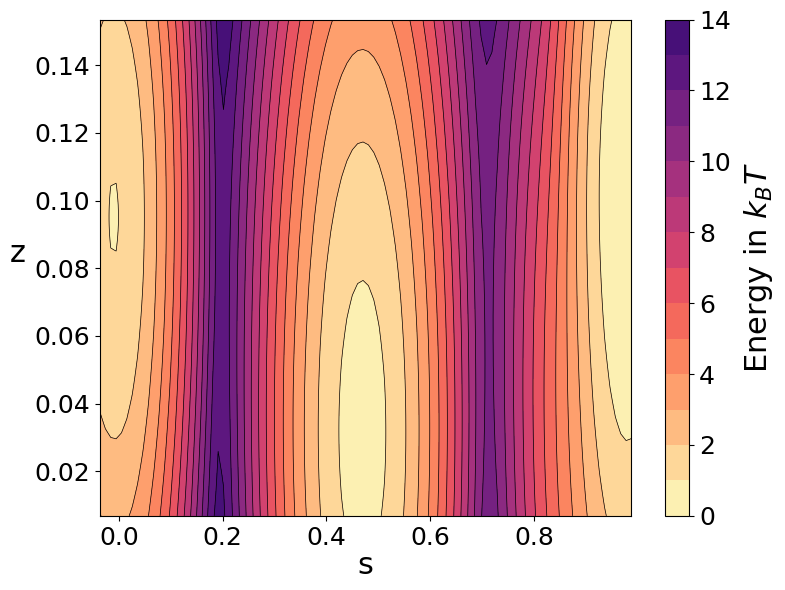

<Figure size 640x480 with 0 Axes>

In [200]:
data=plumed.read_as_pandas("fes2d-DeepLNE-sz.dat" )


x_values = data['model_s']
y_values = data['model_z']
file_free_values = data['file.free']

x_grid, y_grid = np.meshgrid(np.linspace(x_values.min(), x_values.max(), 100),
                                 np.linspace(y_values.min(), y_values.max(), 100))

file_free_values=np.absolute(file_free_values)

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
file_free_grid = griddata((x_values, y_values), file_free_values, (x_grid, y_grid), method='cubic')

levels=np.arange(0.0,15,1)
s = plt.contourf(x_grid, y_grid, file_free_grid,levels, cmap=new_magma)

levels=np.arange(1,15,1)
plt.contour(x_grid, y_grid,file_free_grid,levels,colors='black', linewidths=0.5)

cbar = plt.colorbar(s, shrink=1)
cbar.set_label(r'Energy in $k_BT$', rotation=90, labelpad=8,fontsize=22)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('s',fontsize=22,labelpad=1)
plt.ylabel('z', rotation=0,fontsize=22,labelpad=12)
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

In [205]:
!pwd

/home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Github
